In [31]:
from __future__ import print_function
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import count, desc , col, max, struct
import pandas as pd
import numpy as np

In [2]:
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("churn_prediction")\
        .getOrCreate()

In [3]:
df = spark.read.csv("churn_prediction.csv",header=True)

In [4]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [5]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
shape= (df.count(), len(df.columns))

print(shape)

(7043, 21)


In [7]:
df.select('gender').groupBy('gender').agg(count('gender').alias('total_gender_count')).show()

+------+------------------+
|gender|total_gender_count|
+------+------------------+
|Female|              3488|
|  Male|              3555|
+------+------------------+



In [8]:
df.select('Partner').groupBy('Partner').agg(count('Partner').alias('total_count')).show()

+-------+-----------+
|Partner|total_count|
+-------+-----------+
|     No|       3641|
|    Yes|       3402|
+-------+-----------+



In [9]:
df.select('PhoneService').groupBy('PhoneService').agg(count('PhoneService').alias('total_count')).show()

+------------+-----------+
|PhoneService|total_count|
+------------+-----------+
|          No|        682|
|         Yes|       6361|
+------------+-----------+



In [10]:
df.select('MultipleLines').groupBy('MultipleLines').agg(count('MultipleLines').alias('total_count')).show()

+----------------+-----------+
|   MultipleLines|total_count|
+----------------+-----------+
|No phone service|        682|
|              No|       3390|
|             Yes|       2971|
+----------------+-----------+



In [11]:
df.select('InternetService').groupBy('InternetService').agg(count('InternetService').alias('total_count')).show()

+---------------+-----------+
|InternetService|total_count|
+---------------+-----------+
|    Fiber optic|       3096|
|             No|       1526|
|            DSL|       2421|
+---------------+-----------+



In [21]:
df.select('OnlineSecurity').groupBy('OnlineSecurity').agg(count('OnlineSecurity').alias('total_count')).show()

+-------------------+-----------+
|     OnlineSecurity|total_count|
+-------------------+-----------+
|                 No|       3498|
|                Yes|       2019|
|No internet service|       1526|
+-------------------+-----------+



In [22]:
df.select('PaymentMethod').groupBy('PaymentMethod').agg(count('PaymentMethod').alias('total_count')).show()

+--------------------+-----------+
|       PaymentMethod|total_count|
+--------------------+-----------+
|Credit card (auto...|       1522|
|        Mailed check|       1612|
|Bank transfer (au...|       1544|
|    Electronic check|       2365|
+--------------------+-----------+



## UNIVARIATE ANALYSIS

In [14]:
df1 = df.toPandas()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
def kdeplot(feature):
    plt.figure(figsize=(12, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df1[df1['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df1[df1['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')

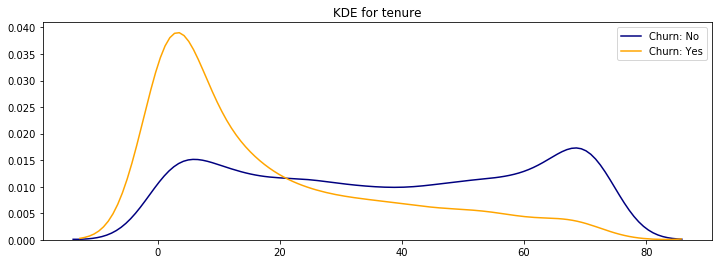

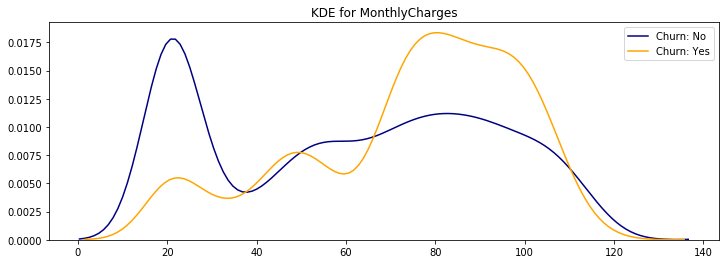

In [16]:
kdeplot('tenure')
kdeplot('MonthlyCharges')

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   object
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   object
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

In [18]:
df1['TotalCharges'] = df1["TotalCharges"].replace(" ",0)
df1["TotalCharges"] = df1["TotalCharges"].astype(float) 

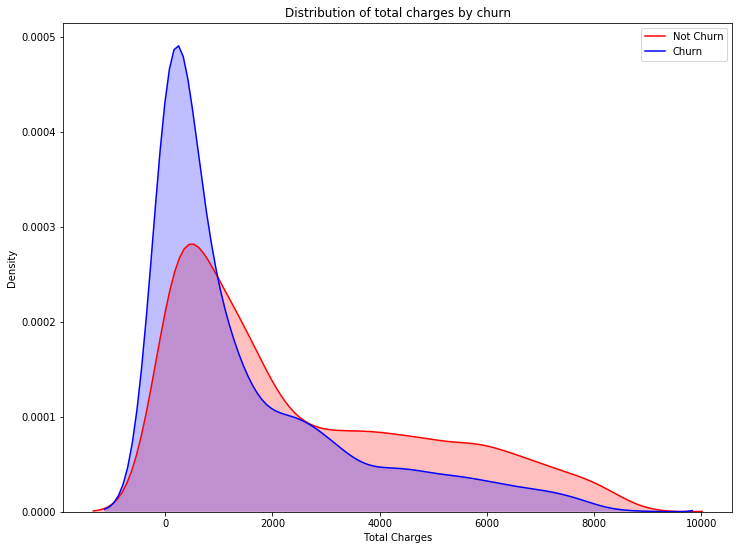

In [51]:
plt.figure(figsize=(12, 9))
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')
plt.show()

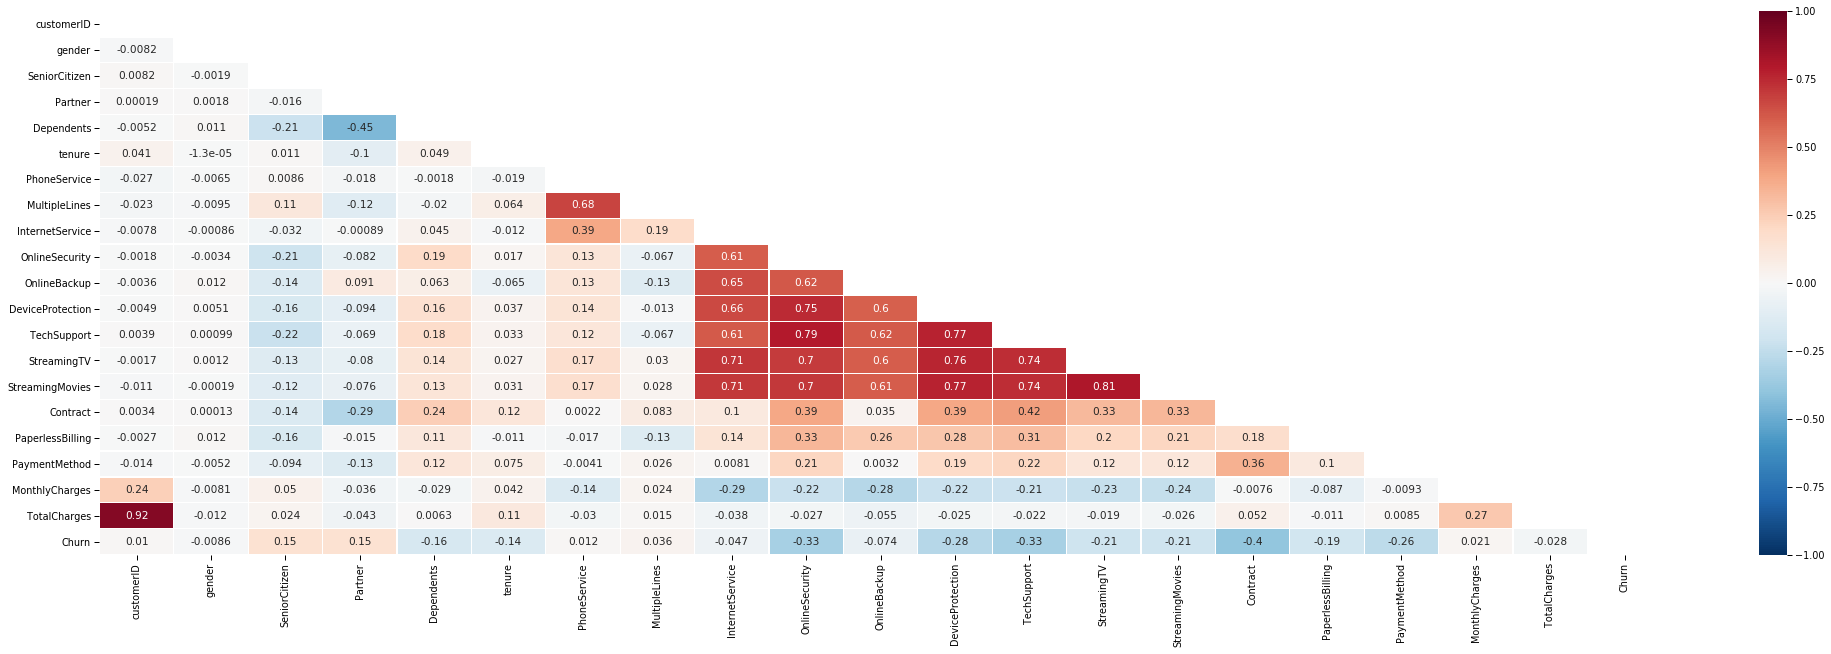

In [26]:
plt.figure(figsize=(35, 10))
corr = df1.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='RdBu_r', vmin=-1, vmax=1)

In [28]:
df1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.8,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.2,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.6,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.4,306.60,Yes
